In [112]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Implement the SSD match algorithm as function disparity_ssd(L, R) that returns a disparity image D(y,x) such that L(y,x) = R(y,x+D(y,x)) when matching from left (L) to right (R).

In [113]:
def disparity_ssd(L, R, window_size=5, search=30):
    ctr = window_size//2
    h,  w = L.shape
    D_L = np.zeros((h, w))
    for i in tqdm(range(ctr, h-ctr)):
        for j in range(ctr, w-ctr):
            window_l = np.asarray(L[i-ctr:i+1+ctr, j-ctr:j+1+ctr], dtype=np.float32)

            r_area = np.asarray(R[i-ctr:i+1+ctr, max(j-search-ctr, 0): min(j+search+ctr+1,w)], dtype=np.float32)
            ssds = cv2.matchTemplate(r_area, window_l, method=cv2.TM_SQDIFF_NORMED)
            
            r_match_idx = max(j-search, ctr) + np.argmin(ssds) 

            D_L[i, j] = np.abs(j - r_match_idx)

    return D_L


## Apply it to the two test images, matching from left to right:

In [114]:
L = cv2.imread('./input/pair0-L.png', 0) * (1.0 / 255.0)  # grayscale, [0, 1]
R = cv2.imread('./input/pair0-R.png', 0) * (1.0 / 255.0)

In [115]:
def show_pair(L, R):
    fig = plt.figure(figsize=(10,10))

    fig.add_subplot(1, 2, 1)
    plt.imshow(L, cmap="gray")
    plt.axis("off")
    fig.add_subplot(1, 2, 2)
    plt.imshow(R, cmap="gray")
    plt.axis("off")
    plt.show()

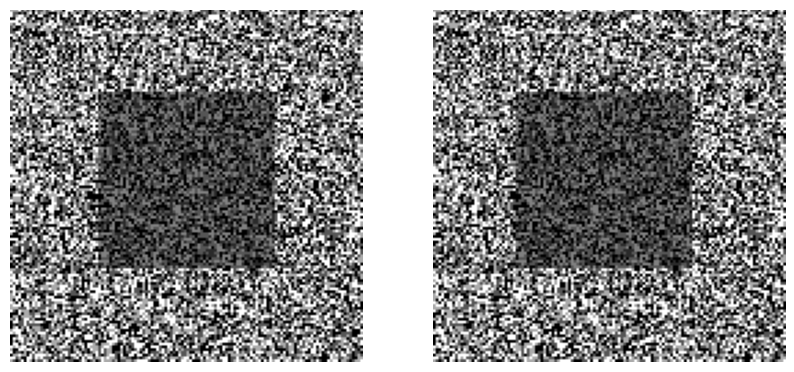

In [116]:
show_pair(L, R)

In [117]:
def show_disparity_ssd(L, R, window_size=11, search=100):
    D_L = disparity_ssd(L, R, window_size, search)
    D_R = disparity_ssd(R, L,window_size, search)
    show_pair(D_L, D_R)
    return D_L, D_R

100%|██████████| 118/118 [00:00<00:00, 171.30it/s]


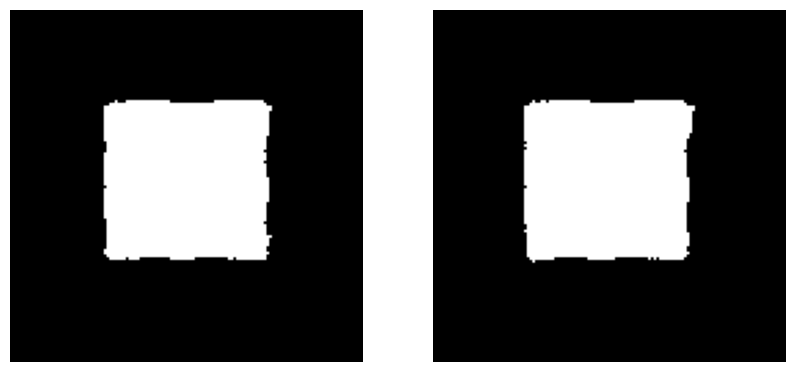

In [118]:
_, _ = show_disparity_ssd(L, R)

# Now we’re going to try this on a real image pair: pair1-L .png and pair1-R .png.  Since these are color images, create grayscale versions. You can use rgb2gray or your own function.

In [119]:
L = cv2.imread('./input/pair1-L.png', 0) * (1.0 / 255.0) 
R = cv2.imread('./input/pair1-R.png', 0) * (1.0 / 255.0)

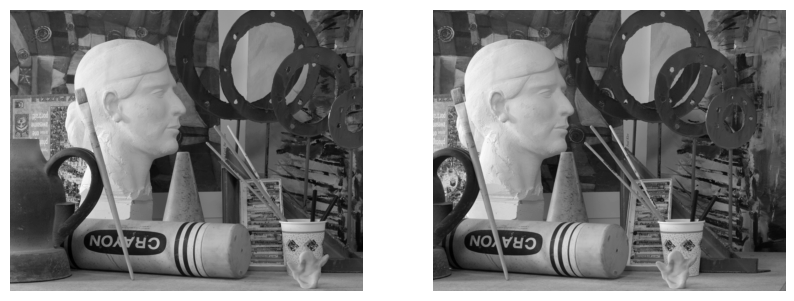

In [120]:
show_pair(L, R)

100%|██████████| 499/499 [00:19<00:00, 25.56it/s]


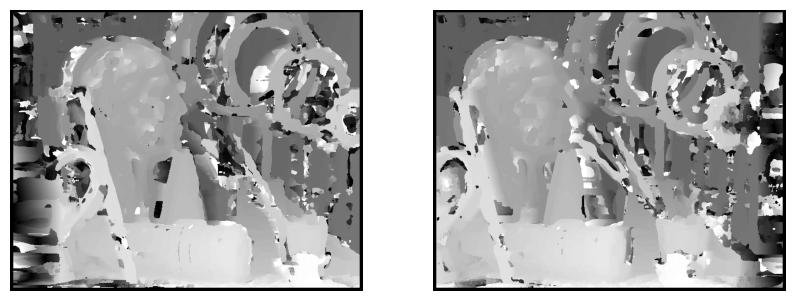

In [121]:
_, _ = show_disparity_ssd(L, R, 13, 100)

# SSD is not very robust to certain perturbations. We’re going to try to see the effect of perturbations:

## Using pair1, add some Gaussian noise, either to one image or both. Make the noise sigma big enough that you can tell some noise has been added. Run SSD match again.

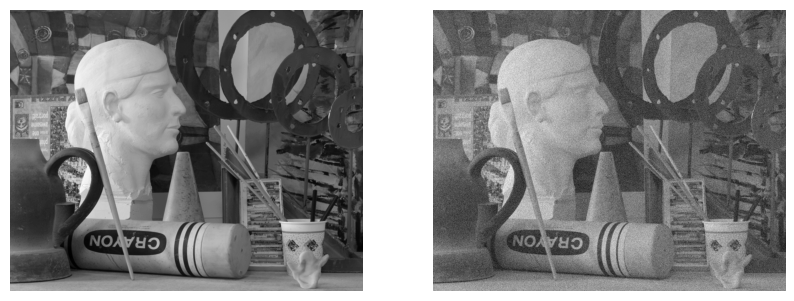

In [122]:
L = cv2.imread('./input/pair1-L.png', 0) * (1.0 / 255.0)  
R = cv2.imread('./input/pair1-R.png', 0) * (1.0 / 255.0)
L_n = L + 0.3*np.random.normal(L.mean(), L.std(), (L.shape[0], L.shape[1]))
show_pair(L, L_n)

100%|██████████| 499/499 [00:19<00:00, 25.83it/s]


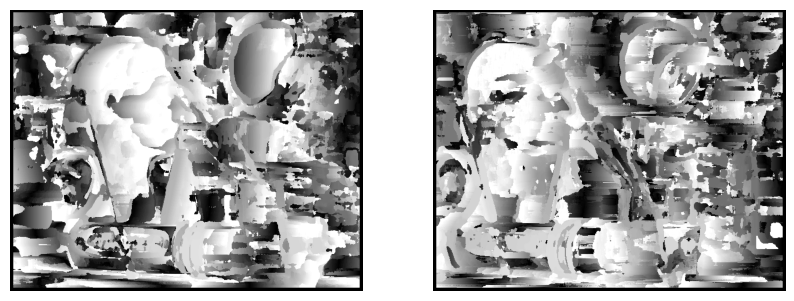

In [123]:
_, _ = show_disparity_ssd(L_n, R, 13, 100)

## Instead of the Gaussian noise, increase the contrast (multiplication) of one of the images by just 10%. Run SSD match again.

100%|██████████| 499/499 [00:19<00:00, 25.79it/s]


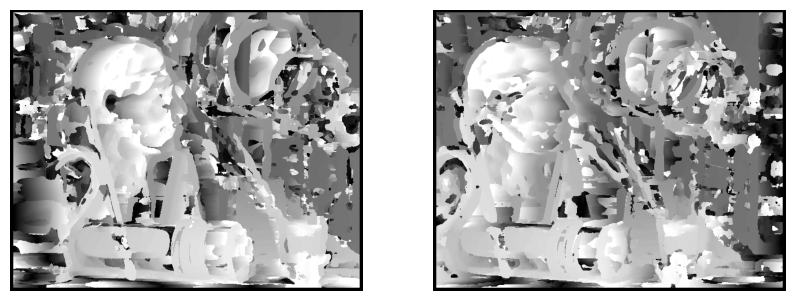

In [124]:
L = cv2.imread('./input/pair1-L.png', 0) * (1.0 / 255.0)  
R = cv2.imread('./input/pair1-R.png', 0) * (1.0 / 255.0)
L = np.clip(L + L*0.1, 0, 1)

_, _ = show_disparity_ssd(L, R, 13, 100)

# Now you’re going to use (not implement yourself unless you want) an improved method, called normalized correlation – this is discussed in the book. The basic idea is that we think of two image patches as vectors and compute the angle between them – much like normalized dot products.

## Implement a window matching stereo algorithm using some form of normalized correlation. Again, write this as a function disparity_ncorr(L, R) that returns a disparity image D(y,x) such that L(y,x) = R(y,x+D(y,x)) when matching from left (L) to right (R).

In [125]:
def disparity_ncorr(L, R, windwo_size=5, search=100):
    h, w = L.shape
    ctr = windwo_size//2 
    D_L = np.zeros((h, w))
    for i in tqdm(range(ctr, h-ctr)):
        for j in range(ctr, w-ctr):
            window_l = np.asarray(L[i-ctr:i+1+ctr, j-ctr:j+1+ctr], dtype=np.float32)

            r_area = np.asarray(R[i-ctr:i+1+ctr, max(j-search-ctr, 0): min(j+search+ctr+1,w)], dtype=np.float32)

            ncorr = cv2.matchTemplate(r_area, window_l, method=cv2.TM_CCOEFF_NORMED)
            r_match_idx = max(j-search, ctr) + np.argmax(ncorr) 
        
            D_L[i, j] = np.abs(j - r_match_idx)
            
    return D_L

In [126]:
def show_disparity_ncorr(L, R, window_size=11, search=100):
    D_L = disparity_ncorr(L, R, window_size, search)
    D_R = disparity_ncorr(R, L,window_size, search)
    show_pair(D_L, D_R)
    return D_L, D_R

## Now test it on both the noisy and contrast-boosted versions from 2-a and 2-b.

2a

100%|██████████| 499/499 [00:19<00:00, 25.60it/s]


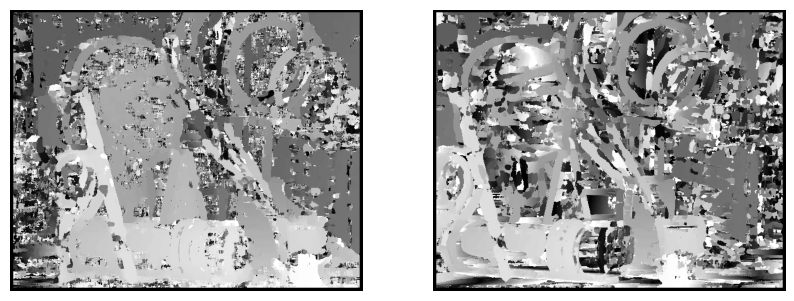

In [127]:
L = cv2.imread('./input/pair1-L.png', 0) * (1.0 / 255.0)  
R = cv2.imread('./input/pair1-R.png', 0) * (1.0 / 255.0)

L += 0.3*np.random.normal(L.mean(), L.std(), (L.shape[0], L.shape[1])) 

_, _ = show_disparity_ncorr(L, R, 13, 100)

2b

100%|██████████| 499/499 [00:19<00:00, 25.83it/s]


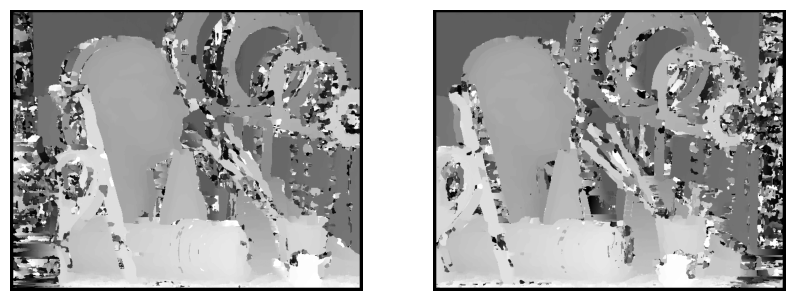

In [128]:
L = cv2.imread('./input/pair1-L.png', 0) * (1.0 / 255.0)  
R = cv2.imread('./input/pair1-R.png', 0) * (1.0 / 255.0)
L = np.clip(L + L*0.1, 0, 1)
_, _ = show_disparity_ncorr(L, R, 13, 100)

# Finally, there is a second pair of images: pair2-L.png and pair2-R.png

## Try your algorithms on this pair. Play with the images – smooth, sharpen, etc. 

In [129]:
L = cv2.imread('./input/pair2-L.png', 0) * (1.0 / 255.0) 
R = cv2.imread('./input/pair2-R.png', 0) * (1.0 / 255.0)

In [130]:
GT_D_L = cv2.imread('./input/pair2-D_L.png', 0) * (1.0 / 255.0) 
GT_D_R = cv2.imread('./input/pair2-D_R.png', 0) * (1.0 / 255.0)

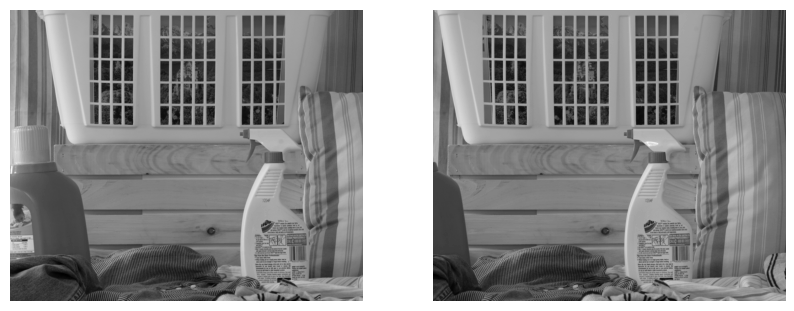

In [131]:
show_pair(L, R)

## disparity map with no preprocessing

100%|██████████| 517/517 [00:20<00:00, 25.65it/s]


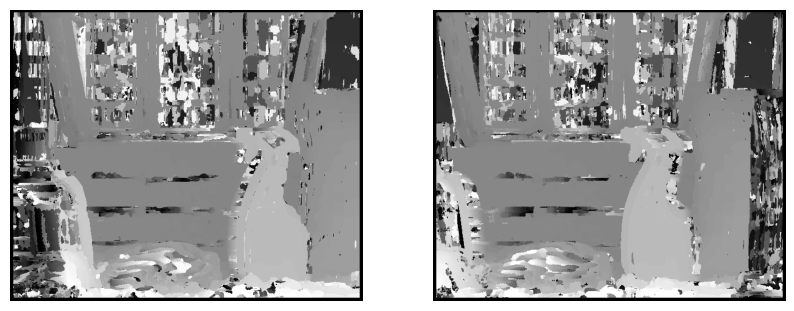

In [132]:
_, _ = show_disparity_ncorr(L, R, 13, 100)

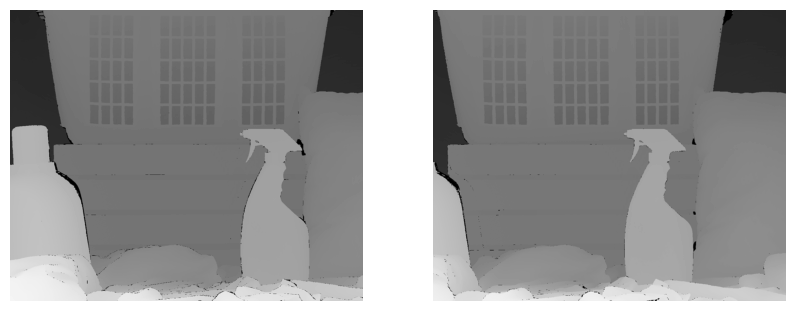

In [133]:
show_pair(GT_D_L, GT_D_R)

## Blur

In [183]:
size = 9

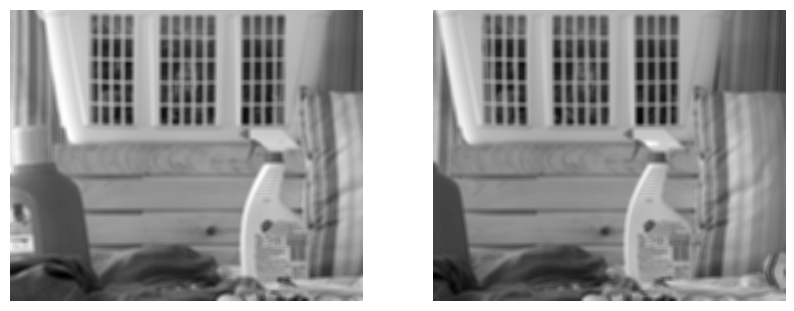

In [188]:
L_smooth = cv2.blur(L, (size,)*2)
R_smooth = cv2.blur(R, (size,) *2)
show_pair(L_smooth, R_smooth)

100%|██████████| 517/517 [00:20<00:00, 25.42it/s]


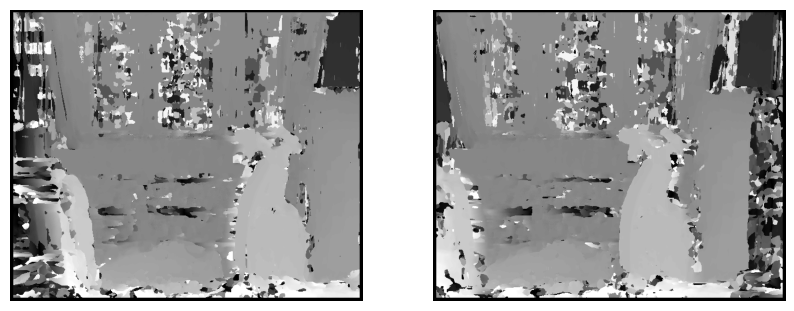

In [189]:
D_L, D_R = show_disparity_ncorr(L_smooth, R_smooth, 13, 100)

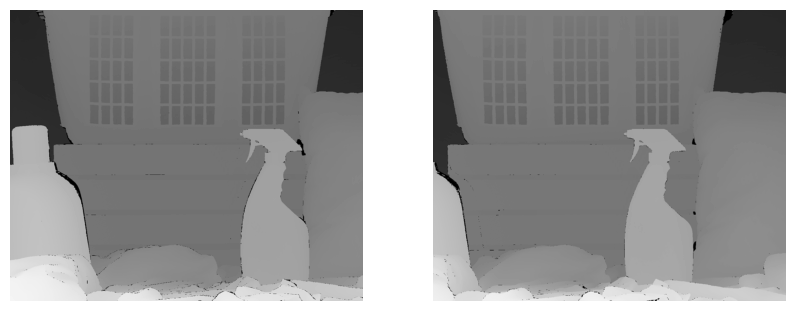

In [190]:
show_pair(GT_D_L, GT_D_R)